# Simple LSTM models for discretized ACTS data

In this notebook we will test out some of our LSTM models for discrete 3D data on some recent ACTS data.

I will use a simple fixed binning for the barrel detector volumes in layer, phi, and z coordinates.

Some models to try:
- Seeded single track hit assignment with backgrounds

In [1]:
# Select a GPU first
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [2]:
from __future__ import print_function

# System imports
import ast

# Data handling
import numpy as np
import pandas as pd

# Machine learning
from keras import layers, models

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Local imports
from data import load_data_events
from drawing import draw_projections

%matplotlib notebook

Using TensorFlow backend.


## Data utilities

In [3]:
def process_hits_data(df, copy_keys=['evtid', 'barcode', 'volid', 'layid']):
    #hits = pd.DataFrame(df[copy_keys])
    x = df.gpos.apply(lambda pos: pos[0])
    y = df.gpos.apply(lambda pos: pos[1])
    z = df.gpos.apply(lambda pos: pos[2])
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return df[copy_keys].assign(z=z.astype(np.float32), r=r.astype(np.float32),
                                phi=phi.astype(np.float32))

def process_particles_data(df, copy_keys=['evtid', 'barcode', 'q']):
    """Split columns and calculate some derived variables"""
    p = df.kin.apply(lambda kin: kin[0])
    theta = df.kin.apply(lambda kin: kin[1])
    phi = df.kin.apply(lambda kin: kin[2])
    pt = p * np.sin(theta)
    eta = -1. * np.log(np.tan(theta / 2.))
    return df[copy_keys].assign(pt=pt.astype(np.float32), eta=eta.astype(np.float32),
                                phi=phi.astype(np.float32))

def process_files(hits_files, particles_files):
    """Load and process a set of hits and particles files"""
    # Column names
    hits_columns = ['hitid', 'barcode', 'volid', 'layid', 'lpos',
                    'lerr', 'gpos', 'chans', 'dir', 'direrr']
    particles_columns = ['barcode', 'vpos', 'kin', 'q']

    # Loop over corresponding files
    hits, particles = [], []
    evtid = 0
    for hits_file, particles_file in zip(hits_files, particles_files):
        # Load this hits file
        hits.append(process_hits_data(
            load_data_events(os.path.join(data_dir, hits_file),
                             columns=hits_columns, start_evtid=evtid)))
        # Load this particles file
        particles.append(process_particles_data(
            load_data_events(os.path.join(data_dir, particles_file),
                             columns=particles_columns, start_evtid=evtid)))
        evtid = particles[-1].evtid.iloc[-1]

    # Concatenate and return the results
    return pd.concat(hits, ignore_index=True), pd.concat(particles, ignore_index=True)

In [4]:
def select_hits(hits, reverse_layers=True):
    # Select all barrel hits
    barrel_hits = hits[(hits.volid == 8) | (hits.volid == 13) | (hits.volid == 17)]
    # Enumerate the barrel detector layers
    layer = pd.Series(-1, index=barrel_hits.index, dtype=np.int32)
    vlid_hit_groups = barrel_hits.groupby(['volid', 'layid'])
    vlids = [(8,2), (8,4), (8,6), (8,8), (13,2), (13,4), (13,6), (13,8), (17,2), (17,4)]
    if reverse_layers:
        vlids = vlids[::-1]
    for i, vlid in enumerate(vlids):
        layer[vlid_hit_groups.get_group(vlid).index] = i
    # Thin the dataframe down to just the values I need
    return barrel_hits[['evtid', 'barcode', 'phi', 'z']].assign(layer=layer)

def select_signal_hits(hits):
    # Select particles with hits in both outer barrel volume layers
    return (hits.groupby(['evtid', 'barcode'])
            .filter(lambda x: (x.layer==0).any() and (x.layer==1).any()))

# Select particles with at least 8 barrel hits
#.filter(lambda x: len(x) > 7)

In [5]:
def binmask_prediction(predictions, inputs, threshold=0.1):
    """
    Finalize a model prediction by masking with the data, selecting the
    top scoring categories, and applying a threshold decision.
    """
    # Mask the predictions with the data (converted to bool)
    pred = predictions * (inputs > 0.5)
    # Find the values of the max predictions
    max_preds = pred.max(axis=2)
    # Keep only the max masked prediction per layer
    pred[pred < max_preds[:,:,np.newaxis]] = 0
    # Apply the threshold for the final boolean prediction
    return pred > threshold

def binmask_accuracy(predictions, inputs, targets, threshold=0.1):
    """Fraction of masked, binarized layers that match the target."""
    preds = binmask_prediction(predictions, inputs, threshold)
    # Convert target to boolean
    targets = (targets > 0.5)
    matches = np.all(preds == targets, axis=2)
    return float(matches.sum()) / matches.size

## Read the data

In [6]:
data_dir = '/bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29'

In [7]:
all_files = os.listdir(data_dir)
hits_files = sorted(f for f in all_files if f.startswith('clusters'))
particles_files = sorted(f for f in all_files if f.startswith('particles'))

num_train_files = 80
if num_train_files > 0:
    train_hits_files = hits_files[:num_train_files]
    train_particles_files = particles_files[:num_train_files]

In [ ]:
hits, particles = process_files(train_hits_files, train_particles_files)

Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_1.csv
Finished event 0
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/particles_1.csv
Finished event 0
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_10.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/particles_10.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_100.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/particles_100.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_11.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/particles_11.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_12.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/particles_12.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_13.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/particles_13.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_14.csv
Loading /bi

Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_72.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/particles_72.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_73.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/particles_73.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_74.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/particles_74.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_75.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/particles_75.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_76.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/particles_76.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_77.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/particles_77.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_78.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000

In [9]:
print('Hits data shape:', hits.shape)
print('Particles data shape:', particles.shape)

Hits data shape: (42159135, 7)
Particles data shape: (3462692, 6)


## Single-track hit assignment

In this case we want to bin all the hits in an event, and we want to do bin classification starting from a track seed.

In [10]:
def build_basic_lstm(length, dim, hidden_dim=128,
                     loss='categorical_crossentropy', final_activation='softmax',
                     optimizer='Nadam', metrics=['accuracy']):
    inputs = layers.Input(shape=(length, dim))
    hidden = layers.LSTM(output_dim=hidden_dim, return_sequences=True)(inputs)
    outputs = layers.TimeDistributed(layers.Dense(dim, activation=final_activation))(hidden)
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

def build_deep_lstm(length, dim, hidden_dim=128,
                    loss='categorical_crossentropy', final_activation='softmax',
                    optimizer='Nadam', metrics=['accuracy']):
    inputs = layers.Input(shape=(length, dim))
    hidden = layers.TimeDistributed(layers.Dense(hidden_dim, activation='relu'))(inputs)
    hidden = layers.LSTM(output_dim=hidden_dim, return_sequences=True)(hidden)
    hidden = layers.TimeDistributed(layers.Dense(hidden_dim, activation='relu'))(hidden)
    outputs = layers.TimeDistributed(layers.Dense(dim, activation=final_activation))(hidden)
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [11]:
def batch_generator(hits, signal_hits, signal_keys, batch_size,
                    layer_bins=10, layer_range=[0, 10],
                    phi_bins=32, phi_range=[-np.pi, np.pi],
                    z_bins=32, z_range=[-1100, 1100],
                    seed_size=3, dtype=np.float32):
    """Batch generator for a fixed phi-Z binning of barrel detector hits."""
    
    # Histogramming function
    get_hist = lambda hits: np.histogramdd(
        (hits.layer.values, hits.phi.values, hits.z.values),
        bins=(layer_bins, phi_bins, z_bins),
        range=(layer_range, phi_range, z_range))[0].astype(np.float32)

    # First, bin all of the event histograms
    evt_hists = hits.groupby('evtid').apply(get_hist)
    # Group signal hits for faster lookups
    sig_hit_groups = signal_hits.groupby(['evtid', 'barcode'])
    
    # Drop any remaining hits after last full batch
    num_batches = signal_keys.shape[0] // batch_size
    keys = signal_keys[:num_batches*batch_size].reshape((num_batches, batch_size, -1))
    
    # Infinite loop over epochs
    while True:
        
        # Loop over batches
        for batch_keys in keys:
            
            # Get the evt hists in this batch
            batch_evtids = batch_keys[:,0]
            batch_evt_hists = np.stack(evt_hists[batch_evtids])

            # Construct the sig hists in this batch
            batch_sig_hits = map(sig_hit_groups.get_group, map(tuple, batch_keys))
            batch_sig_hists = np.stack(map(get_hist, batch_sig_hits))
            # One liner
            #batch_sig_hists = np.stack(map(get_hist, map(sig_hit_groups.get_group, map(tuple, batch_keys))))
            
            # Fill seed layers with signal hits only
            batch_evt_hists[:,:seed_size] = batch_sig_hists[:,:seed_size]
            # Clip target to binary
            batch_sig_hists[batch_sig_hists > 1] = 1
            # Reshape to model input and output
            model_input = batch_evt_hists.reshape((batch_size, layer_bins, -1))
            model_target = batch_sig_hists.reshape((batch_size, layer_bins, -1))
            yield model_input, model_target

In [ ]:
%%time
reverse_layers = True
good_hits = select_hits(hits, reverse_layers=reverse_layers)
signal_hits = select_signal_hits(good_hits)

# Find and shuffle the samples
keys = signal_hits[['evtid', 'barcode']].drop_duplicates().values
np.random.shuffle(keys)
print('Number of samples available:', keys.shape[0])

Number of samples available: 1091294
CPU times: user 30min 21s, sys: 2.86 s, total: 30min 24s
Wall time: 30min 23s


In [14]:
# Data binning config
layer_bins, layer_range = 10, (0, 10)
phi_bins, phi_range = 64, (-np.pi, np.pi)
z_bins, z_range = 64, (-1100, 1100)

# Number of seed layers
seed_size = 2

# Tensor shapes
hist_shape = (layer_bins, phi_bins, z_bins)
flat_shape = (hist_shape[0], -1)

# Model config
hidden_dim = 256

# Training config
#valid_frac = 0.2
batch_size = 64
num_epoch = 10
samples_per_epoch = (keys.shape[0] // batch_size) * batch_size

In [15]:
# Construct the model
model = build_basic_lstm(length=layer_bins, dim=phi_bins*z_bins,
                         hidden_dim=hidden_dim)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 10, 4096)      0                                            
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 10, 256)       4457472     input_1[0][0]                    
____________________________________________________________________________________________________
timedistributed_1 (TimeDistribut (None, 10, 4096)      1052672     lstm_1[0][0]                     
Total params: 5,510,144
Trainable params: 5,510,144
Non-trainable params: 0
____________________________________________________________________________________________________


In [ ]:
# Train the model with the batch generator
train_batcher = batch_generator(good_hits, signal_hits, keys, batch_size=batch_size,
                                layer_bins=layer_bins, layer_range=layer_range,
                                phi_bins=phi_bins, phi_range=phi_range,
                                z_bins=z_bins, z_range=z_range,
                                seed_size=seed_size)
history = model.fit_generator(train_batcher, nb_epoch=num_epoch,
                              samples_per_epoch=samples_per_epoch)

Epoch 1/10
1091264/1091264 [==============================] - 1557s - loss: 0.4817 - acc: 0.8509  


<IPython.core.display.Javascript object>


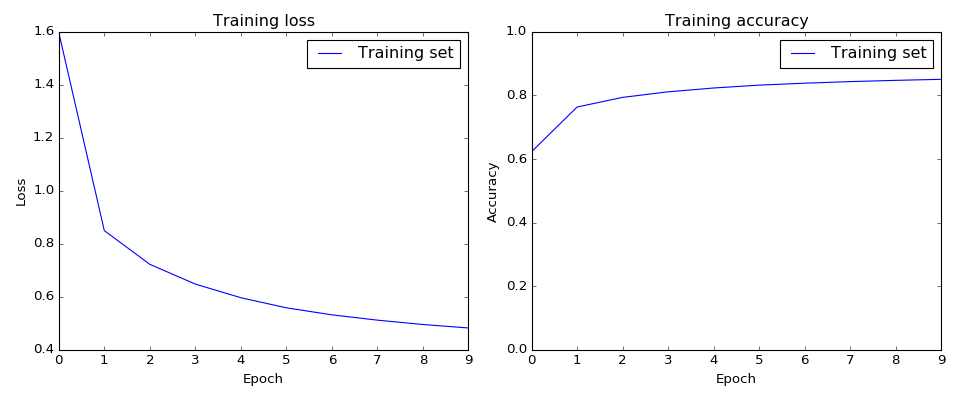

In [17]:
draw_train_history(history, draw_val=False);

## Test set evaluation

In [18]:
num_test_files = 1
test_hits_files = hits_files[num_train_files:num_train_files+num_test_files]
test_particles_files = particles_files[num_train_files:num_train_files+num_test_files]

In [19]:
test_hits, test_particles = process_files(test_hits_files, test_particles_files)

Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_81.csv
Finished event 0
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/particles_81.csv
Finished event 0


In [20]:
print('Hits data shape:', test_hits.shape)
print('Particles data shape:', test_particles.shape)

Hits data shape: (528029, 7)
Particles data shape: (43351, 6)


In [21]:
%%time
test_good_hits = select_hits(test_hits, reverse_layers=reverse_layers)
test_signal_hits = select_signal_hits(test_good_hits)

# Find and shuffle the samples
test_keys = test_signal_hits[['evtid', 'barcode']].drop_duplicates().values
num_test = test_keys.shape[0]
print('Number of test samples:', num_test)

Number of test samples: 13636
CPU times: user 23 s, sys: 104 ms, total: 23.1 s
Wall time: 22.8 s


In [22]:
# Create a new batcher for the test set
test_batcher = batch_generator(test_good_hits, test_signal_hits, test_keys,
                               batch_size=num_test, seed_size=seed_size,
                               layer_bins=layer_bins, layer_range=layer_range,
                               phi_bins=phi_bins, phi_range=phi_range,
                               z_bins=z_bins, z_range=z_range)
test_input, test_target = test_batcher.next()
test_pred = model.predict(test_input)
test_binpred = binmask_prediction(test_pred, test_input)

Model input


<IPython.core.display.Javascript object>


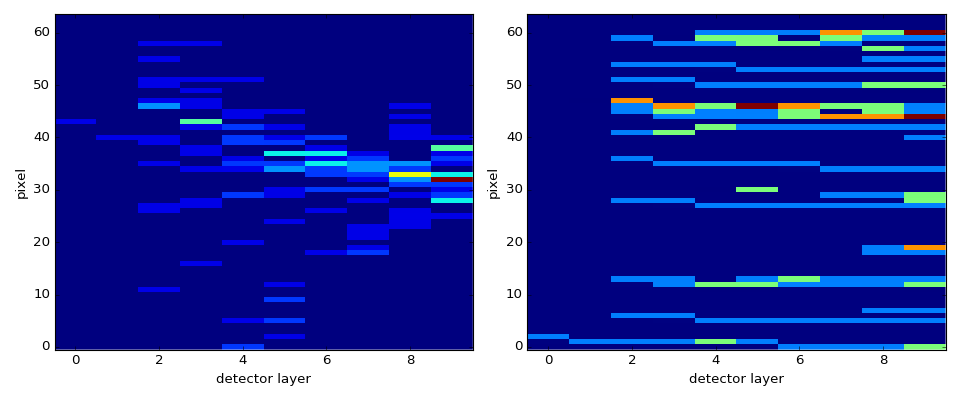

Model target


<IPython.core.display.Javascript object>


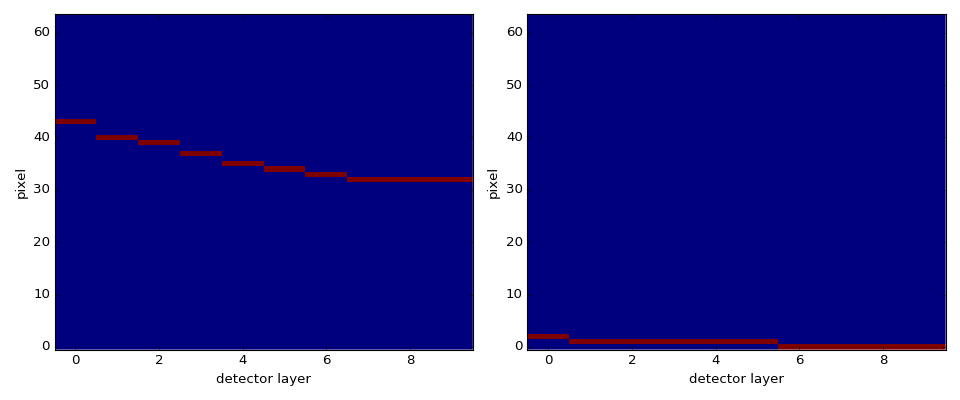

Model prediction


<IPython.core.display.Javascript object>


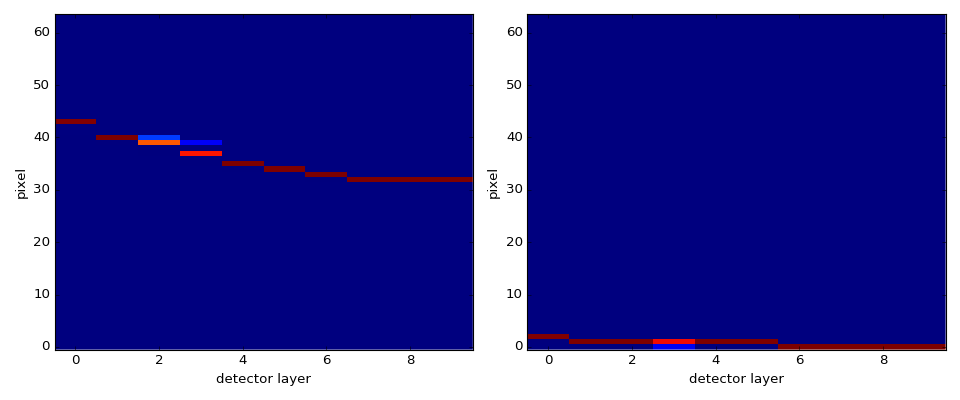

In [27]:
# Visualize predictions
i = 0
print('Model input')
draw_projections(test_input[i].reshape(hist_shape))
print('Model target')
draw_projections(test_target[i].reshape(hist_shape))
print('Model prediction')
draw_projections(test_pred[i].reshape(hist_shape));
#print('Binarized model prediction')
#draw_projections(test_binpred[i].reshape(hist_shape));

In [24]:
binmask_accuracy(test_pred[:, seed_size:],
                 test_input[:, seed_size:],
                 test_target[:, seed_size:])

0.8096490906424171

In [25]:
binmask_accuracy(test_pred, test_input, test_target)

0.8367849809328248